In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [3]:
import pymc.sampling_jax

# Lesson Introduction: Art Class
Build intuition through creativity

## Section 10: How to a draw a line
* Showcase our challenge: Modeling C02 data
* Draw a line using linear regression
* Draw a couplle more lines with Bayesian Linear Regression

## Section 20: How to draw a wiggly line
* Discuss where plain linear regression misses
* How we can improve our model with additional term

## Section 30: A different method for drawing

## Section 40: Placeholder

# Section 10: How to a draw a line
The first model that everyone tries (probably)

## Mauna Loa 
<center>
  <img src="img/Aa_channel_flow_from_Mauna_Loa.jpg"  />
</center>

Lets first talk about Hawaii, specifically Mauna Loa, which is quite beautiful as you can see here

On this island there is a research facility where they conduct experiments.

## Mauna Loa CO2 Experiment

<center>
    <div>
       <img src="img/9oyu_2ghf_141031.jpg" height="400" />
    </div>
</center>

- Been measuring C02 for the last X years
- A key experiment in the study of climate change
- Longest running continuous collection of atmospheric CO2 measurements


#  Mauna Loa CO2 dataset


In [4]:
data = pd.read_csv("data/co2_mm_mlo.csv", header=51)

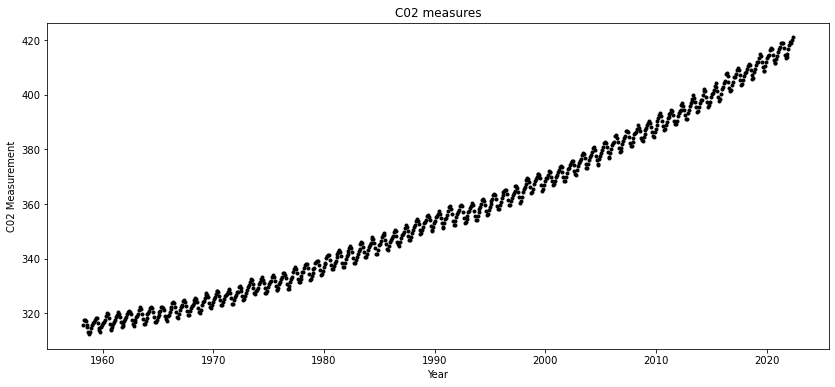

In [5]:
plt.figure(figsize=(14,6))
plt.plot(data["decimal date"], data["average"], "k.")
plt.title("C02 measures")
plt.xlabel("Year")
plt.ylabel("C02 Measurement");

Here's the time series, theres a number of things we can note immediately. Is the trend, at a gance it looks roughly linear but perhaps not quite, it also has a seasonal pattern. Specifically it has some sort of cycle

## Zooming In

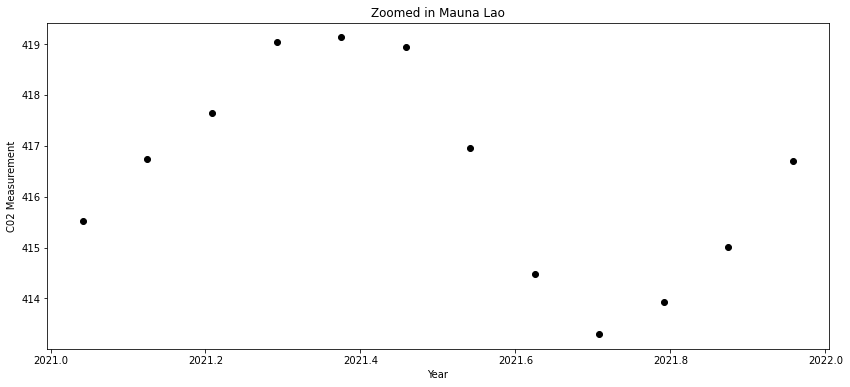

In [6]:
year = data[(data["decimal date"] > 2021) & (data["decimal date"] <= 2022)]

plt.figure(figsize=(14,6))
plt.plot(year["decimal date"], year["average"], "ko")
plt.title("Zoomed in Mauna Lao")
plt.xlabel("Year")
plt.ylabel("C02 Measurement");

If we zoom in we can see a couple more features. The data has an an annual cycle which peaks in the spring, lowest in the fall

## Lets create a model
<center>
    <div>
       <img src="img/PyMC.png" height="400" />
    </div>
</center>

We're statisticians so buiding models is what we do. 

##  Lets create a model using a principled workflow

<center>
    <div>
       <img src="img/IB_Bayesian_workflow.jpg" height="400" />
    </div>
</center>


But we're also principled statisticians that follow the bayesian workflow
Let's start simple, and try and increase complexity.
Sometimes it's hard to resist the temptation to reach for the most "advanced" approach you know first.  It's always better to work up in this direction than the opposite.

We'lll

## Modeling the trend with a function

$$\huge{CO2\_Level = f(x)}$$

Keeping it simple lets model the trend.

For now lets ignore the small year to year variation First lets try fitting the whole thing with a straight line.  Let's ignore the annual up-and-down pattern (the technical term is called "seasonality", link to description of term) 

Lets also start simple and redefine the basics
Mathematical functions are the main tools we use to fit data.  Whether we are extrapolating or forecasting, or interpolating, we need something that given an `x`, outputs a `y`, or the range of plausible `y` values.  


## Linear Function

$$CO2\_Level = mx + b$$

Lets start by using familiar function you've seen before but before you skip this slide lets talk through it.
We're making a bold statement here. We're saying that if we have model parameters m and b, we can estimate C02_level by plugging in a value of X.



## Estimating the  parameters

$$CO2\_Level = \textbf{m}x + \textbf{b}$$

Now we still need to figure out What should we guess for $m$ and $b$?

- $\beta_0$ is the Y intercept, so what's the CO2 value here at year = 0?  Kind of hard.  It's usually good to normalize our data, so lets
rescale things so that the data starts near year "zero".  We can do this by subtracting the smallest x date from all our x values. Doing so won't change the results of our model, so long as we make sure to add it back in later.

# *A* way to pick an intercept


In [5]:
intercept = data.sort_values(["decimal date"])["average"].head(1)
intercept

0    315.7
Name: average, dtype: float64

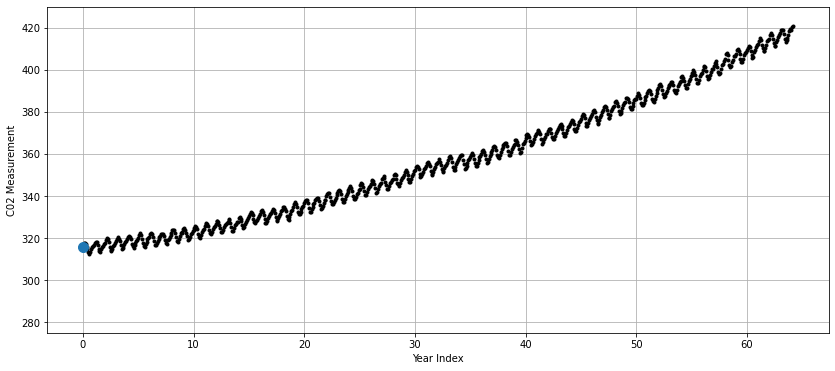

In [6]:
plt.figure(figsize=(14,6))
plt.plot(data["decimal date"] - data["decimal date"].min(), data["average"], "k.");

plt.grid(True)
plt.plot(0, intercept.values, marker="o", markersize=10)
plt.ylim([275, 430])
plt.xlabel("Year Index")
plt.ylabel("C02 Measurement");

Let's just say we decide the intercept is where the first data point is. We're the modelers here so we can pick our parameters how we choose.

Lets just assume the first point is the intercept

# *A* way to pick a slope

In [7]:
xl = np.linspace(0, 70, 200)

possible_line1 = 315.7 + 1.5 * xl

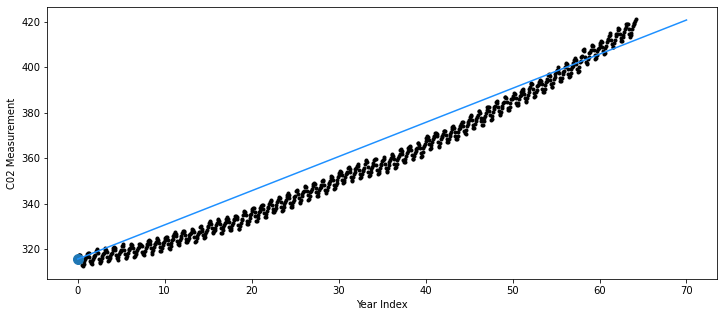

In [8]:
plt.figure(figsize=(12,5))
plt.plot(data["decimal date"] - data["decimal date"].min(), data["average"], "k.")
plt.plot(0, intercept.values, marker="o", markersize=10)

plt.plot(xl, possible_line1, "dodgerblue")
plt.xlabel("Year Index")
plt.ylabel("C02 Measurement");

**TODO**: Add rise over run picture

Now that we've picked an intercept all we need to do is pick a slope. Lets use rise over run

The slope parameter `m` might be a little easier.  Slope is defined as "rise over run", so lets try calculating. We might as well use that as one of our guesses.  Eyeballing it with upward curve makes this a bit tricky, but lets also try 300, and 290.   

The slope parameter `m` might be a little easier.  Slope is defined as "rise over run", so lets try calculating that at a few spots.  

## Multiple Estimations

In [9]:
xl = np.linspace(0, 70, 200)

possible_line1 = 315.7 + 1.5 * xl
possible_line2 = 300.0 + 2.0 * xl
possible_line3 = 290.0 + 2.0 * xl

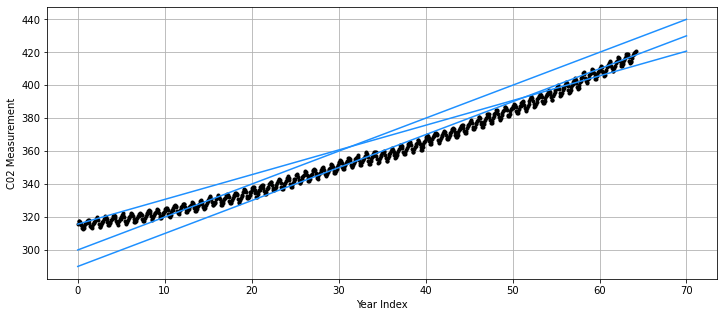

In [10]:
plt.figure(figsize=(12,5))
plt.plot(data["decimal date"] - data["decimal date"].min(), data["average"], "k.");
plt.plot(xl, possible_line1, "dodgerblue")
plt.plot(xl, possible_line2, "dodgerblue")
plt.plot(xl, possible_line3, "dodgerblue")

plt.grid(True)
plt.xlabel("Year Index")
plt.ylabel("C02 Measurement");

We can pick a couple more data points and repeat this process
- Lets start from year 10 to year 30:  Looking at the chart, at year 10, CO2 is about 320.  At year 30 CO2 is about 350.  That gives $\frac{350 - 320}{30-10} = 1.5$. - Year 30 to year 60: $\frac{410 - 350}{60-30} = 2.0$
- Year 40 to year 50: $\frac{385 - 370}{50-40} = 2.0$

Lets plug in our guesses and plot a few lines.

These are clearly pretty rudimentary guesses, but they at least look plausible?

How can we be more rigorous mathematically though? 

# OLS Regression
Add statsmodel to dependencies later, or switch this to matrix inverse method

In [11]:
import statsmodels.formula.api as sm
result = sm.ols(formula="A ~ B + C", data=df).fit()

NameError: name 'df' is not defined

Matrix inverse method, least squares, don't necessarily need statsmodels, formula language, all that.  Have folks seen that before? Not sure how much explanation is needed here. 

In [25]:
x = data["decimal date"].values - data["decimal date"].min()
X = np.vstack((np.ones(len(x)), x)).T 

y = data["average"].values

((b_est, m_est), _, _, _) = np.linalg.lstsq(X, y, rcond=None)
b_est, m_est

(305.5912365334089, 1.6081969456682905)

The least squares estimates for the y-intercept is 305.6, and for the slope its 1.6, which are pretty close to our previous guesses.

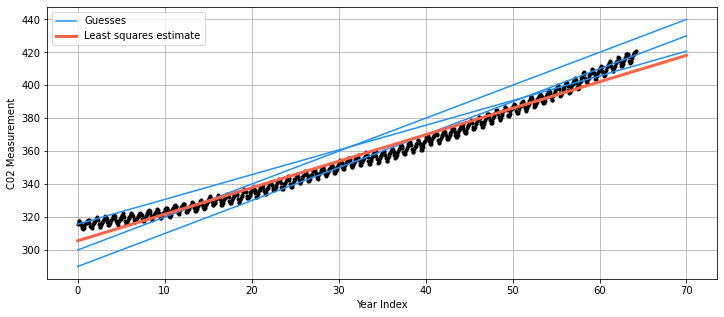

In [29]:
plt.figure(figsize=(12,5))
# plot data
plt.plot(data["decimal date"] - data["decimal date"].min(), data["average"], "k.");

# plot guesses
plt.plot(xl, possible_line1, "dodgerblue")
plt.plot(xl, possible_line2, "dodgerblue")
plt.plot(xl, possible_line3, "dodgerblue", label="Guesses")

# plot least squares estimate
plt.plot(xl, b_est + m_est * xl, color="tomato", lw=3, label="Least squares estimate");


plt.legend();
plt.grid(True)
plt.xlabel("Year Index")
plt.ylabel("C02 Measurement");

Now some of you might be saying, well obviously a better way is to minimize the sum of squares between each observed data point and the line to estimate the optimal m and b.

Some other people might even be a bit fancier and say, we're going to least squares regression or ordinary linear regression

And most people dont say either, but instead just load up excel or their favorite ML library, press run, get a line, and think thats theres no better way

# Bayesian Regression

In [13]:
with pm.Model() as model:
    b = pm.Normal("b", mu=300, sigma=100)
    m = pm.Normal("m", mu=0.0, sigma=100)
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    x_ = pm.MutableData("x", data["decimal date"] - data["decimal date"].min())
    mu = pm.Deterministic("mu", m * x_ + b)
    
    pm.Normal("y", mu=mu, sigma=sigma, observed=data["average"])
    

But we're bayesian here, and we know how powerful this estimation method can be not to get one line, but all lines. Lets go ahead and use PyMC to get all possible lines **and** their relative plausability.

## Fit the model in PyMC

In [14]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, m, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


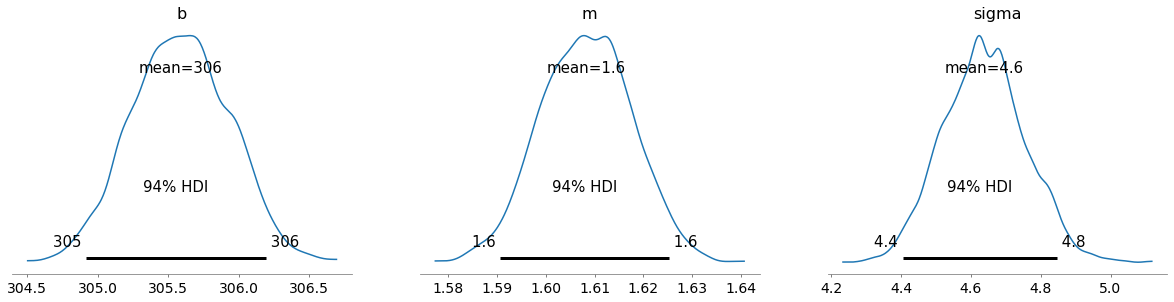

In [15]:
az.plot_posterior(idata.posterior, var_names=["b", "m", "sigma"]);

We can see that with a Bayesian approach, we can let the model produce guesses, and associate each guess with a "plausibility score", or a posterior probablity. 


## Making Predictions

In [16]:
with model:
    pm.set_data({'x': xl})
    ppc = pm.sample_posterior_predictive(idata, var_names=["mu", "y"])
    idata.extend(ppc)

We also can make predictions about future observations themselves

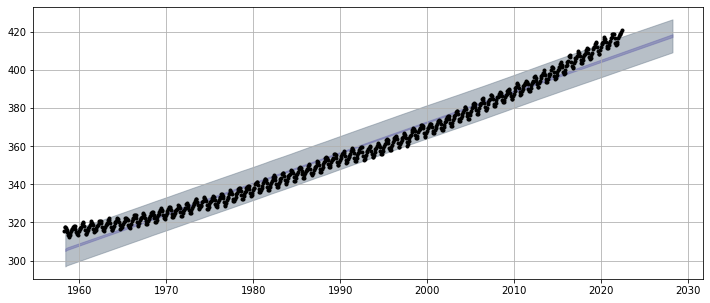

In [17]:
plt.figure(figsize=(12,5))

az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.mu), color="slateblue")
az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.y), color="slategray")

plt.plot(data["decimal date"], data["average"], "k.");

plt.grid(True);

- Our guesses were pretty good, but PyMC's guesses are better
- Blue shaded is posterior predictive estimate of the line.  Since we have so much data, PyMC is pretty confident about this.
- Gray shaded is posterior predictive estimate of the data generated by the line.  It's wide enough to cover most of the data.

## Could we do better though?

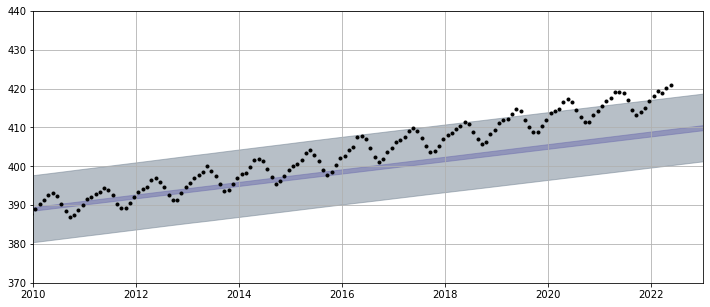

In [18]:
plt.figure(figsize=(12,5))

az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.mu), color="slateblue")
az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.y), color="slategray")

plt.plot(data["decimal date"], data["average"], "k.");
plt.xlim(2010, 2023)
plt.ylim(370, 440)

plt.grid(True)
plt.xlabel("Year")
plt.ylabel("C02 Measurement");

If we zoom in again though we can more clearly see that there's extra patterns were missing. In the next sections we'll address those as well. For now let's talk through our section recap

## Section Recap
* We want to estimate C02 Levels starting with a line

### Review
* Drew a single line using 
  * a elementary school method
  * Ordinary Least Square Regression
  * Drew many lines using Bayes Linear Regression

### Key takeaways
* Functions take inputs and provide us estimates
  * Needed to estimate the parameters
* We *assumed* a functional form mx+b


# Section 20:  How to draw a wiggly line
*Adding* more nuance

$$CO2\_Level = \textbf{m}x + \textbf{b}$$

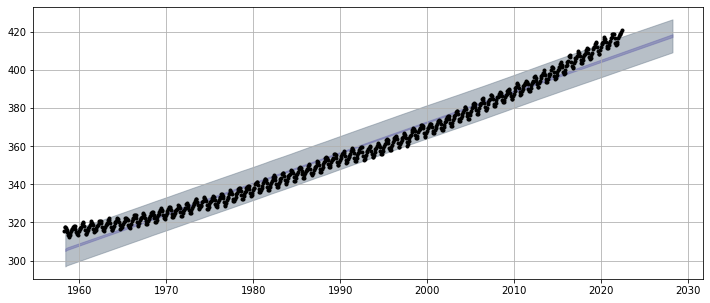

In [19]:
plt.figure(figsize=(12,5))

az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.mu), color="slateblue")
az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.y), color="slategray")

plt.plot(data["decimal date"], data["average"], "k.");

plt.grid(True)

plt.xlabel("Year")
plt.ylabel("C02 Measurement");

In the last section we roughly we defined a linear model to capture the trend. We were able to estimate the parameters of that linear model using Bayesian method. However because our model only defined a line all, we got back straight lines

## What about all periodicity?

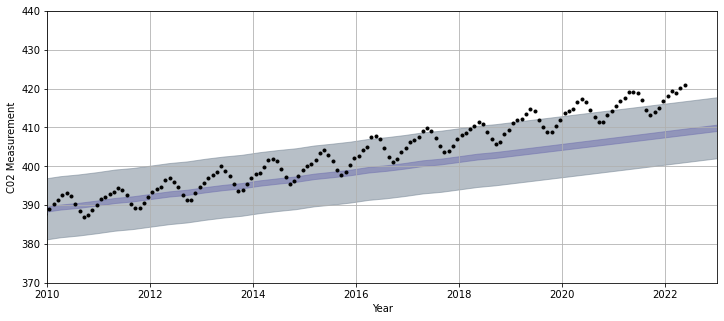

In [28]:
plt.figure(figsize=(12,5))

az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.mu), color="slateblue")
az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.y), color="slategray")

plt.plot(data["decimal date"], data["average"], "k.");
plt.xlim(2010, 2023)
plt.ylim(370, 440)

plt.grid(True)
plt.xlabel("Year")
plt.ylabel("C02 Measurement");

We say that were missing the squigliness though, more specifically referred to are periodicity.

## Zooming in on one period, or cycle

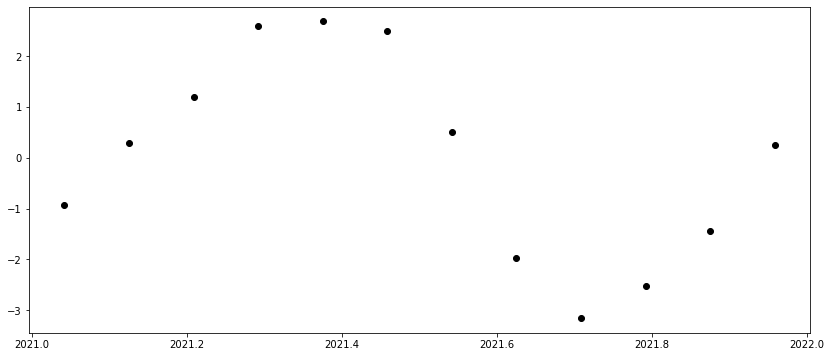

In [37]:
year = data[(data["decimal date"] > 2021) & (data["decimal date"] <= 2022)]

plt.figure(figsize=(14,6))
plt.plot(year["decimal date"], year["average"] - year["average"].mean(), "ko");

By inspecting these points up close we can see a familiar function. Try guessing what it is. We'll pause for a second to give a moment to think.

Did you say sine? Or did you guess cosine? Either way you're right

## Overlaying out random guess

$$CO2\_Level = sin(year* \pi)$$

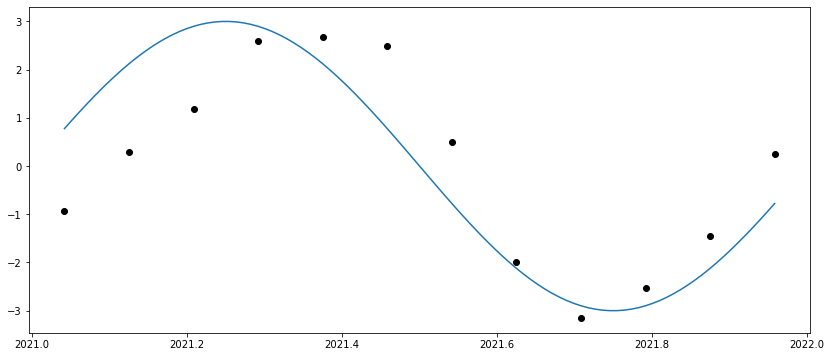

In [34]:
year = data[(data["decimal date"] > 2021) & (data["decimal date"] <= 2022)]

plt.figure(figsize=(14,6))
plt.plot(year["decimal date"], year["average"] - year["average"].mean(), "ko");

xl = np.linspace(year["decimal date"].min(), year["decimal date"].max(), 100)
plt.plot(xl, 3*np.cos(2 * np.pi * xl * 1.0 - 0.5 * np.pi));

Like our trend we can use use the sine function parameterized by x, or year in this case, to model our data.

We guessed some parameters like before but it's great, there's certainly room for improvement.  This does give us some OK starting points though, and we can use these to help us set priors for our PyMC model.

- frequency: 1 (cycle per year)
- amplitude: 3.  After normalizing the observed data by subtracting the mean, we can see the cycle goes up and down from about -3 to 3. 
- phase: $-\frac{\pi}{2}$, this gets cosine to start at zero and increase first, which sort of matches the data, but should be a free parameter in the model.

## Sine waves don't go up

In [47]:
data["decimal date"]
sin_component = 3*np.cos(2 * np.pi * xl)

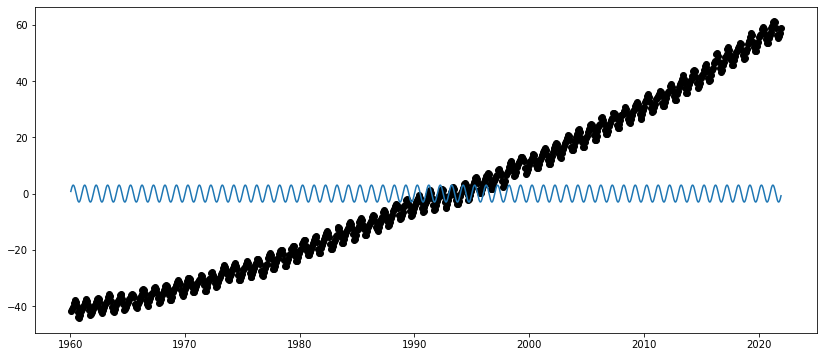

In [49]:
year = data[(data["decimal date"] > 1960) & (data["decimal date"] <= 2022)]

plt.figure(figsize=(14,6))
plt.plot(year["decimal date"], year["average"] - year["average"].mean(), "ko");

xl = np.linspace(year["decimal date"].min(), year["decimal date"].max(), 10000)
plt.plot(xl, 3*np.cos(2 * np.pi * xl * 1.0 - 0.5 * np.pi));

We have another problem though, sine waves don't go up but we have a solution for that

## Additive models

In [72]:
xl = np.linspace(year["decimal date"].min(), year["decimal date"].max(), 10000)

sin_component = 3*np.cos(2 * np.pi * xl * 1.0 - 0.5 * np.pi)

# We bot these from the Bayesian estimation
m, b =1.6, 306
linear_component = m*(xl-year["decimal date"].min()) + b

squiggly_line = linear_component + sin_component

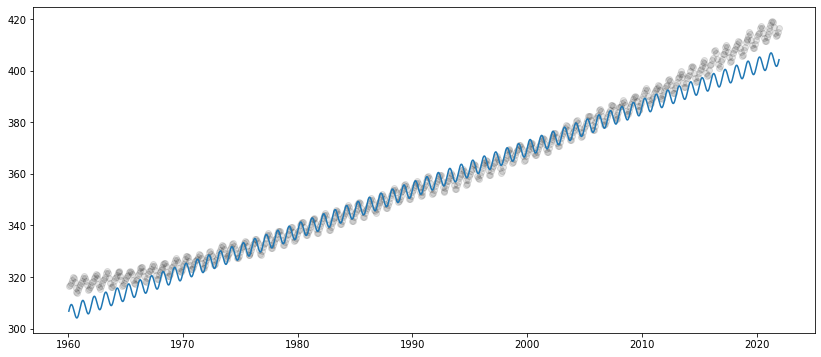

In [71]:
plt.figure(figsize=(14,6))
plt.plot(year["decimal date"], year["average"], "ko", alpha=.1);

plt.plot(xl, squiggly_line);

What we could do is add our linear term and our sin wave together to create a new model. Now we get the effects of both together. Better, now instead of guessing parameter let's use Bayesian methods to estimate our parameters again.

## Bayesian Additive model

In [73]:
with pm.Model() as model:
    b = pm.Normal("b", mu=300, sigma=100)
    m = pm.Normal("m", mu=0.0, sigma=100)
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    x_ = pm.MutableData("x", data["decimal date"] - data["decimal date"].min())
    mu_linear = pm.Deterministic("mu_linear", m * x_ + b)
    
    
    A = pm.HalfNormal("A", sigma=5)
    phi = pm.Normal("phi", mu=-np.pi / 2, sigma=0.1)
    freq = pm.Normal("freq", mu=1.0, sigma=0.1)
    mu_periodic = pm.Deterministic("mu_periodic", A * pm.math.cos(2 * np.pi * x_ * freq + phi))
    
    mu = pm.Deterministic("mu", mu_linear + mu_periodic)
    
    pm.Normal("y", mu=mu, sigma=sigma, observed=data["average"])
    
    
with model:
    idata = pm.sample(tune=2000, chains=2, target_accept=0.98)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, m, sigma, A, phi, freq]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 40 seconds.


You'll notice a couple of extra terms now.

## Our parameter estimates

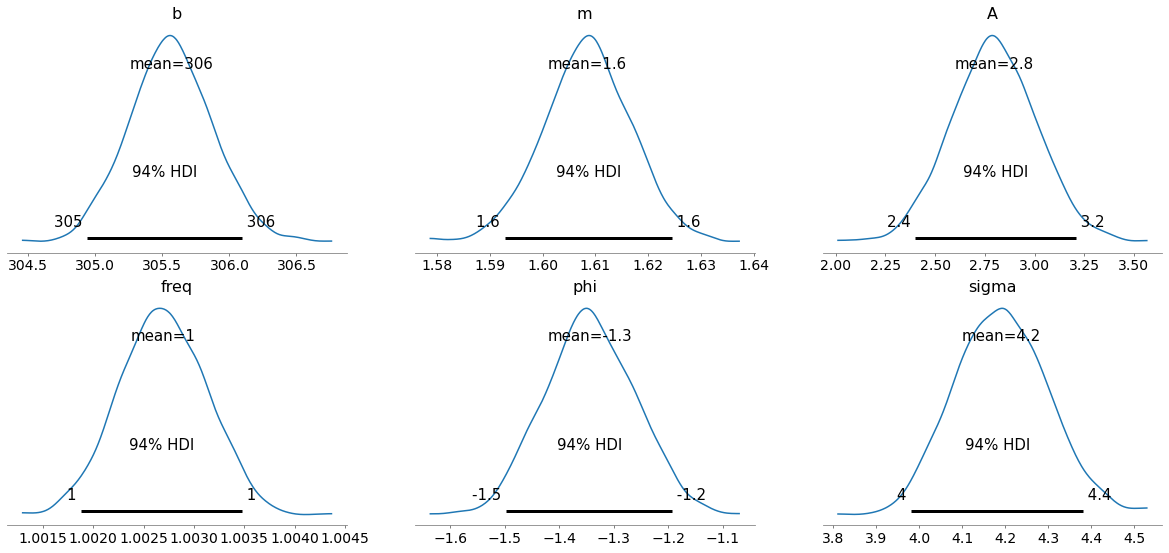

In [22]:
az.plot_posterior(idata.posterior, var_names=["b", "m", "A", "freq", "phi", "sigma"]);

Now using ArviZ let's plot the posterior 

- It was a bit tricky to get the sampler to converge, but now it looks like the results are sensible.  The parameter estimates are also somewhat in line with our guesses.  
- Now lets look at the posterior predictive and draw some samples

In [23]:
xl = np.linspace(0, 70, 1000)

with model:
    pm.set_data({'x': xl})
    ppc = pm.sample_posterior_predictive(idata, var_names=["mu", "y"])
    idata.extend(ppc)

## Making prections

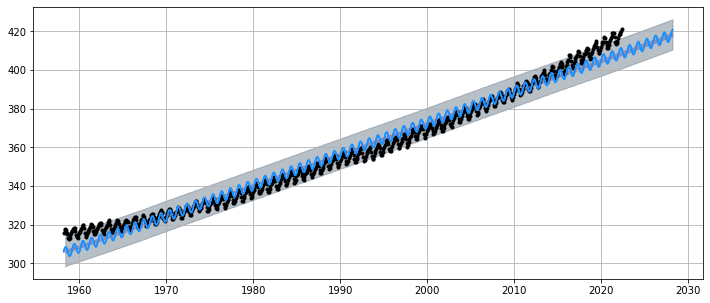

In [24]:
plt.figure(figsize=(12,5))

az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.mu), color="slateblue")
az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.y), color="slategray")

mu_samples = idata.posterior_predictive.mu.stack(sample=["chain", "draw"]).isel(sample=[1,2,3]).values

plt.plot(data["decimal date"], data["average"], "k.");
plt.plot(xl + data["decimal date"].min(), mu_samples, color='dodgerblue');

plt.grid(True);

Usnig 
- the results look similar to the straight line model, except when we look at individual samples of `mu` we can see the seasonal pattern reflected. 
- Lets zoom in also and look at the small scale structure

## Zooming into our posterior predictive

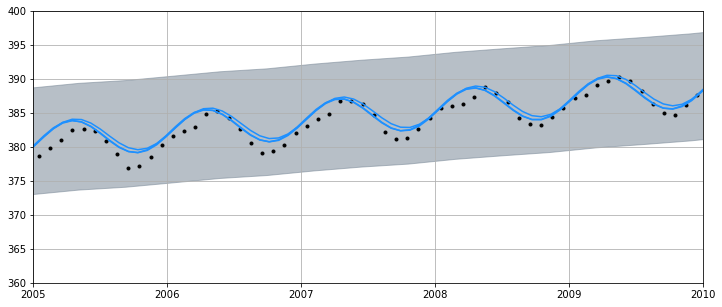

In [25]:
plt.figure(figsize=(12,5))

az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.y), color="slategray")

mu_samples = idata.posterior_predictive.mu.stack(sample=["chain", "draw"]).isel(sample=[1,2,3]).values

plt.plot(data["decimal date"], data["average"], "k.");
plt.plot(xl + data["decimal date"].min(), mu_samples, color='dodgerblue');

plt.grid(True);
plt.xlim([2005, 2010]);
plt.ylim([360, 400]);

Even at the best looking part of the curve, there are still pretty obvious issues still here.

What is wrong:
- Linear term seems insufficient.  Upward increasing trend
- "Cosine" seems insufficient.  Is it a perfect sine wave?  Or is something that's almost a sine wave, but still has a repeating pattern.
- How much more fine structure are we missing in the data?

Now you might say well lets go add another function, but where does it stop?

- With this functional approach, nothing stops us from forecasting infinitely far into the future.  Is that reasonable?

## The steps to our current approach

1. Guess at a functional form of the series
2. Estimate parameters for that function
3. See what's wrong
4. Go back to step 1

Continuing with this approach, what might we try?  Coming up with functional forms is difficult and it doesnt always work!  Also, how much do we care about these parameters? We might just to know what the CO2 levels might be, not necssarily care about the components of the model or their parameters

Now don't get us wrong, additive models are a valid approach in many situations, but that's not our case. Nor is this is the right course! The good news is there is another approach, but before we get ahead of ourselves lets talk through our section recap

## Section Recap
* Functions can be added together to create new models
  * Knowing as additive models
* The modeler still needs to decide what the functions are
  * And estimate the parameters even if they're not if interest
* With the C02 estimation even with an extended additive model there's issues

# Section 30

Let's take a different approach, lets try drawing, and lets think carefully about *how* we are drawing.  To start, lets focus on the most recent years worth of data.

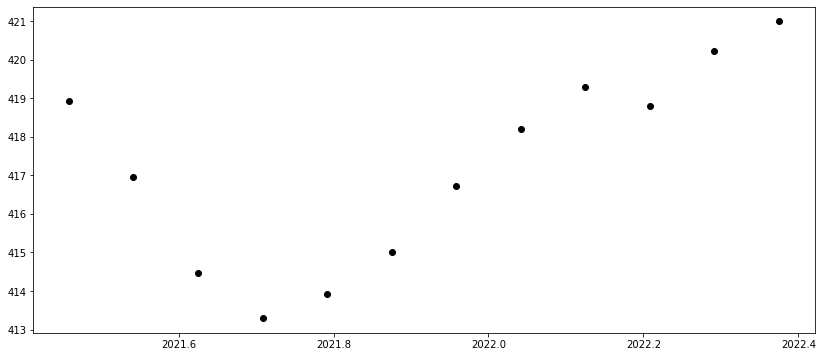

In [44]:
year = data.sort_values("decimal date").tail(12)

plt.figure(figsize=(14,6))
plt.plot(year["decimal date"], year["average"], "ko");

- Connect the dots?   No, we shouldn't expect to predict CO2 at every point.  The process by which CO2 gets into the atmosphere is too complicated.  The line we draw shouldn't pass through every point perfectly, but there's clearly some kind of overall pattern happening.
- Lets start by drawing somewhere in the middle.  

In [81]:
### HIDE THIS CODE
# Going to pretend to draw the MAP estimate of this model as what we "draw", but suprise, it's actually a GP. 

subset = data.sort_values("decimal date").tail(24)
x = subset["decimal date"].values - subset["decimal date"].min()

y_mu = subset["average"].mean()
y_sd = subset["average"].std()
y = (subset["average"].values - y_mu) / y_sd

coords = {'time': subset['decimal date'].values}

with pm.Model(coords=coords) as model:
    
    eta = pm.HalfNormal('eta', sigma=1)
    ell = pm.Gamma('ell', alpha=2, beta=3)
    cov_eq = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    
    eta_per = pm.HalfNormal('eta_per', sigma=1)
    ell_per = pm.Gamma('ell_per', alpha=2, beta=3)
    cov_per = eta_per**2 * pm.gp.cov.Periodic(1, period=1.0, ls=ell_per)
        
    gp_eq = pm.gp.Marginal(cov_func=cov_eq)
    gp_per = pm.gp.Marginal(cov_func=cov_per)
    
    gp = gp_eq + gp_per
    
    sigma = pm.HalfNormal("sigma", sigma=1)
    lik = gp.marginal_likelihood("lik", X=x[:, None], y=y, noise=sigma, dims='time')
    
with model:
    idata = pm.sampling_jax.sample_blackjax_nuts()

Compiling...
Compilation time =  0:00:03.456490
Sampling...
Sampling time =  0:00:06.985890
Transforming variables...
Transformation time =  0:00:00.387592
Computing Log Likelihood...
Log Likelihood time =  0:00:00.618996


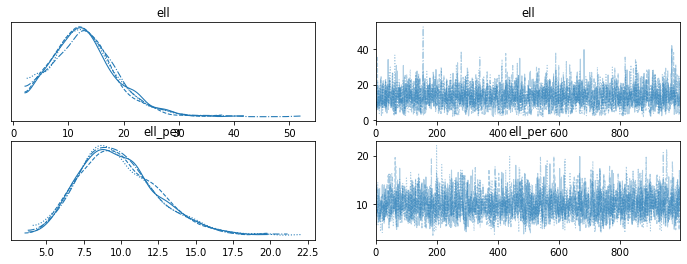

In [82]:
az.plot_trace(idata, var_names=['ell', 'ell_per'], transform=lambda x: x * 12);

In [83]:
xnew = np.linspace(np.min(x), np.max(x) + 0.5, 200)

with model:
    f = gp.conditional('f', Xnew=xnew[:, None], jitter=1e-4)
    ppc = pm.sample_posterior_predictive(idata, var_names=['f'])
    
idata.extend(ppc)

In [79]:
def plot_range(xmin, xmax):
    fig = plt.figure(figsize=(14, 6))
    ax = fig.gca()

    f = idata.posterior_predictive.f.stack(sample=['chain', 'draw']).mean(dim='sample')
    gp_posterior = y_sd * f + y_mu 

    x = xnew + subset["decimal date"].min()
    keep_ix = [ix for ix, v in enumerate(x) if xmin < v < xmax]
    
    ax.plot(x[keep_ix], gp_posterior[keep_ix]); 
    ax.plot(subset["decimal date"], subset["average"], "o", mec="w");

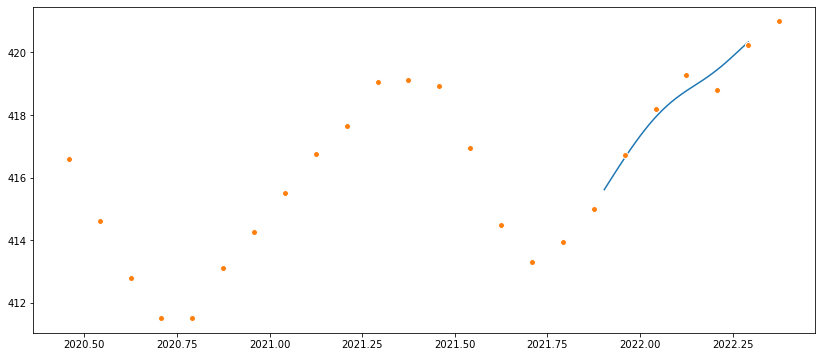

In [80]:
plot_range(2021.9, 2022.3)